In [1]:
import pandas as pd
import networkx as nx
import gurobipy as gp
from gurobipy import GRB

# Load population data
population_df = pd.read_csv('/Users/dannilin/Desktop/OR_Class/Final_Project/NM/NM.population', sep=" ", skiprows=1, names=["Index", "Population"])

# Create a dictionary for population lookup
population_dict = population_df.set_index('Index')['Population'].to_dict()

# Load and parse adjacency data to create a graph G
G = nx.Graph()
with open('/Users/dannilin/Desktop/OR_Class/Final_Project/NM/NM.dimacs', 'r') as file:
    for line in file:
        if line.startswith('e'):
            _, u, v = line.split()
            G.add_edge(int(u), int(v))
G.add_nodes_from(range(max(G.nodes()) + 1))  # Assuming continuous numbering


In [2]:
import math

# Total population
total_population = population_df['Population'].sum()

# Number of districts and deviation
k = 3  # Number of districts
deviation = 0.01  # 1% population deviation

# Calculate L and U
L = math.ceil((1 - deviation / 2) * total_population / k)
U = math.floor((1 + deviation / 2) * total_population / k)

# Print the results
print("Using L =", L, "and U =", U, "and k =", k)

Using L = 702312 and U = 709369 and k = 3


In [3]:
print(total_population)

2117522


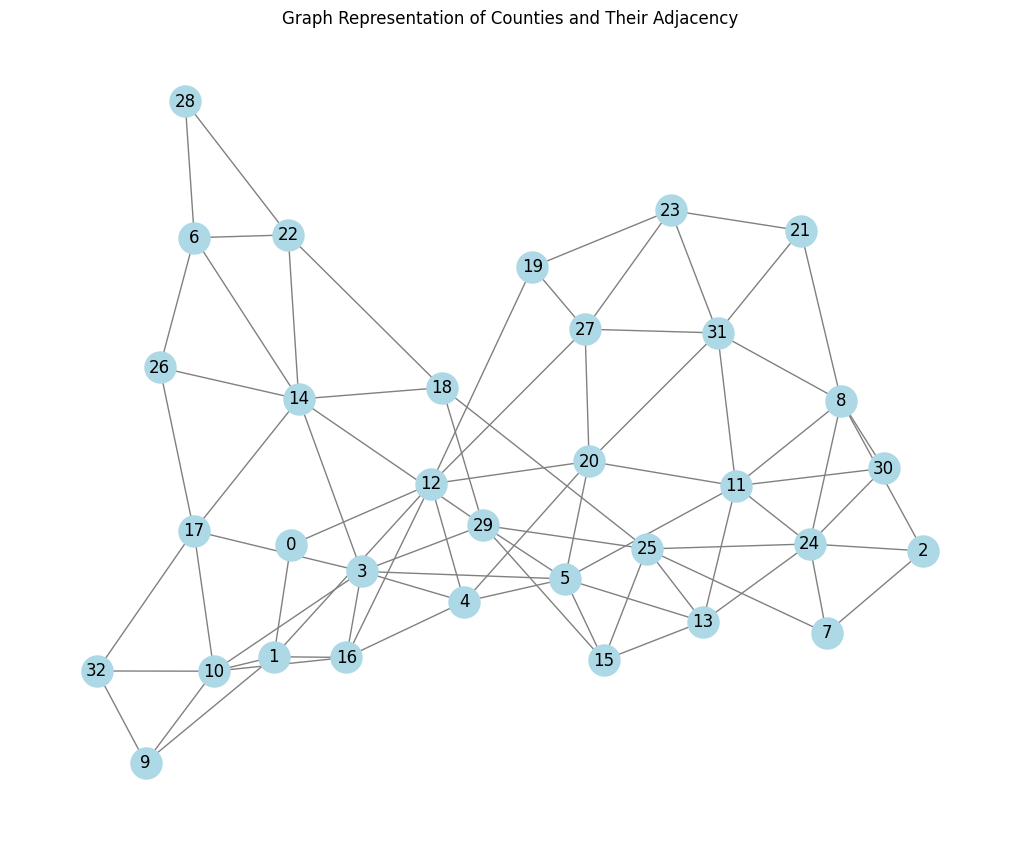

In [4]:
import matplotlib.pyplot as plt
# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.title("Graph Representation of Counties and Their Adjacency")
plt.show()

In [5]:
# Create the Gurobi model
m = gp.Model()

# Number of districts and deviation
k = 3  # Number of districts from previous calculation

# Variables
x = m.addVars(G.nodes, range(k), vtype=GRB.BINARY)  # x[i, j] equals 1 when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u, v] equals 1 when edge {u, v} is cut

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


In [6]:
# Objective: Minimize cut edges
m.setObjective(gp.quicksum(y[u, v] for u, v in G.edges), GRB.MINIMIZE)

# Constraints

# Each county assigned to one district
for i in G.nodes:
    m.addConstr(gp.quicksum(x[i, j] for j in range(k)) == 1)

# Population constraints for each district
for j in range(k):
    m.addConstr(gp.quicksum(population_dict[i] * x[i, j] for i in G.nodes) >= L)
    m.addConstr(gp.quicksum(population_dict[i] * x[i, j] for i in G.nodes) <= U)

# Edge cut constraints
for i, j in G.edges:
    for v in range(k):
        m.addConstr(x[i, v] - x[j, v] <= y[i, j])

# Update and optimize the model
m.update()

In [7]:
# Create the directed version of G
DG = nx.DiGraph(G)

# Add root variables: r[i, j] is 1 if node i is the "root" of district j
r = m.addVars(G.nodes, range(k), vtype=GRB.BINARY)

# Add flow variables: f[u, v] is the amount of flow sent across arc uv in DG
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)

m.update()

In [8]:
# The 'big-M' value as proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Add constraints to the model

# Each district j should have one root
for j in range(k):
    m.addConstr(gp.quicksum(r[i, j] for i in DG.nodes) == 1)

# If node i is not assigned to district j, then it cannot be its root
for i in DG.nodes:
    for j in range(k):
        m.addConstr(r[i, j] <= x[i, j])

# Flow constraints: if not a root, consume some flow; if a root, only send out flow
for v in G.nodes:
    m.addConstr(gp.quicksum(f[u, v] - f[v, u] for u in DG.neighbors(v)) >= 1 - M * gp.quicksum(r[v, j] for j in range(k)))

# Do not send flow across cut edges
for i, j in G.edges:
    m.addConstr(f[i, j] + f[j, i] <= M * (1 - y[i, j]))

# Update and optimize the model
m.update()
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 486 rows, 432 columns and 1941 nonzeros
Model fingerprint: 0x6a3fbbcd
Variable types: 156 continuous, 276 integer (276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Presolve time: 0.00s
Presolved: 486 rows, 432 columns, 1950 nonzeros
Variable types: 156 continuous, 276 integer (276 binary)

Root relaxation: objective 0.000000e+00, 192 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  108          -    0.00000      -     -    0s
     0     0    3.63573    0  112          -    3.63573      -     -    0s
H    0     0  

In [9]:
# Print the number of cut edges
print("The number of cut edges is", m.objVal)

# Retrieve the districts
districts = [[i for i in G.nodes if x[i, j].X > 0.5] for j in range(k)]

# Map district numbers to counties
# Using the population DataFrame to find the counties in each district
district_counties = [[population_df.loc[population_df['Index'] == i, 'Index'].iloc[0] for i in districts[j]] for j in range(k)]

# Calculate district populations
# Summing the populations of the counties in each district
district_populations = [sum(population_df.loc[population_df['Index'] == i, 'Population'].iloc[0] for i in districts[j]) for j in range(k)]

# Print district info
for j in range(k):
    print("District", j, "has population", district_populations[j], "and contains counties", district_counties[j])


The number of cut edges is 19.0
District 0 has population 707195 and contains counties [13, 25, 18]
District 1 has population 702632 and contains counties [0, 12, 2, 7, 8, 24, 4, 20, 11, 21, 30, 31, 19, 27, 23]
District 2 has population 707695 and contains counties [1, 9, 10, 16, 3, 5, 14, 17, 29, 15, 6, 22, 26, 28, 32]


In [10]:
district_counties

[[13, 25, 18],
 [0, 12, 2, 7, 8, 24, 4, 20, 11, 21, 30, 31, 19, 27, 23],
 [1, 9, 10, 16, 3, 5, 14, 17, 29, 15, 6, 22, 26, 28, 32]]

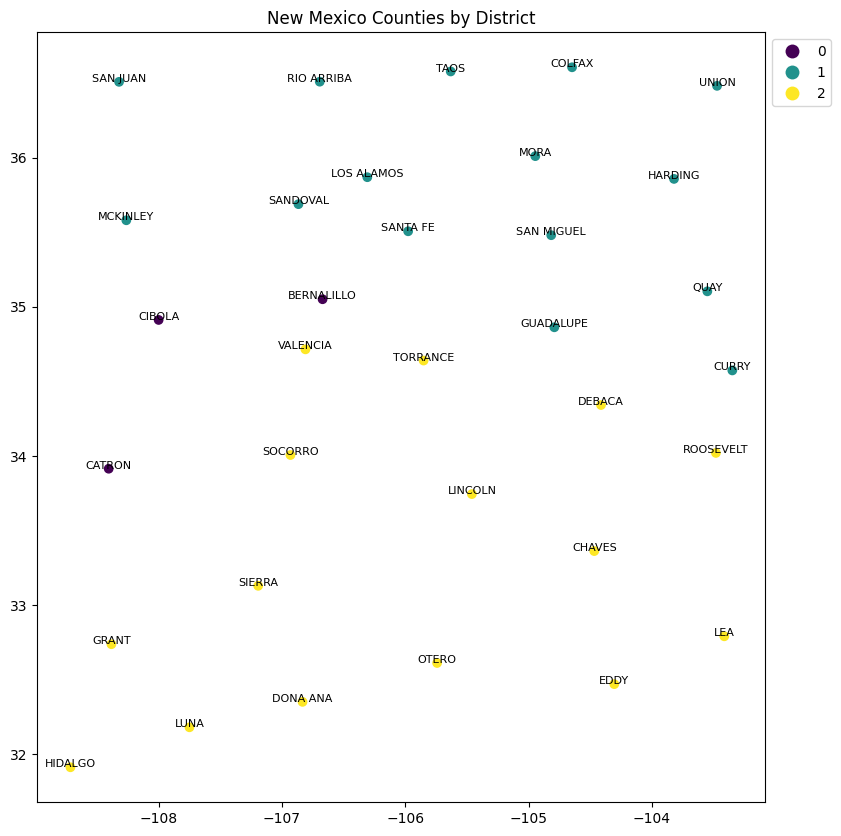

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
nm_counties_gdf = gpd.read_file('/Users/dannilin/Desktop/OR_Class/Final_Project/NM/maps/NM_centers.shp')  # Replace with the actual path

# FIPS code to county name mapping
fips_to_county = {
    '35001': 'BERNALILLO', '35003': 'CATRON', '35005': 'CHAVES', '35006': 'CIBOLA', 
    '35007': 'COLFAX', '35009': 'CURRY', '35011': 'DEBACA', '35013': 'DONA ANA', 
    '35015': 'EDDY', '35017': 'GRANT', '35019': 'GUADALUPE', '35021': 'HARDING', 
    '35023': 'HIDALGO', '35025': 'LEA', '35027': 'LINCOLN', '35028': 'LOS ALAMOS', 
    '35029': 'LUNA', '35031': 'MCKINLEY', '35033': 'MORA', '35035': 'OTERO', 
    '35037': 'QUAY', '35039': 'RIO ARRIBA', '35041': 'ROOSEVELT', '35043': 'SANDOVAL', 
    '35045': 'SAN JUAN', '35047': 'SAN MIGUEL', '35049': 'SANTA FE', '35051': 'SIERRA', 
    '35053': 'SOCORRO', '35055': 'TAOS', '35057': 'TORRANCE', '35059': 'UNION', '35061': 'VALENCIA'
    # Add more mappings if needed
}

# Read the file and create the mapping dictionary
node_to_fips = {}
with open('/Users/dannilin/Desktop/OR_Class/Final_Project/NM/NM.hash', 'r') as file:
    for line in file:
        node_number, fips_code = line.strip().split()
        node_to_fips[int(node_number)] = fips_code

# Define the districts based on your model's output
districts = district_counties

# Create a DataFrame from the district assignments
assignment_df = pd.DataFrame([(node, district) for district, nodes in enumerate(districts) for node in nodes], columns=['node', 'district'])

# Map node numbers to FIPS codes
assignment_df['GEOID20'] = assignment_df['node'].apply(lambda x: node_to_fips.get(x, None))

# Add county names to the assignment DataFrame
assignment_df['CountyName'] = assignment_df['GEOID20'].map(fips_to_county)

# Merge the assignment DataFrame with the shapefile GeoDataFrame
merged_gdf = nm_counties_gdf.merge(assignment_df, on='GEOID20', how='left')

# Plot the map with district assignments and county names
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='district', ax=ax, categorical=True, legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}, cmap='viridis')

# Annotate each county with its name
for idx, row in merged_gdf.iterrows():
    plt.annotate(text=row['CountyName'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y), 
                 horizontalalignment='center', fontsize=8)
plt.title("New Mexico Counties by District")
plt.show()
